In [197]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 70)
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import seaborn as sns

In [2]:
fake = pd.read_csv('2021-09-03_fake_interview_data.csv')

In [3]:
fake.head()

,unique_id,sentilink_id_theft_score,sentilink_synthetic_score,label,is_id_theft,is_synthetic,charged_off,booked
0,53e42eae795f8,NaN,20,NaN,NaN,NaN,False,False
1,c9d46c6858d21,42.0,52,NaN,NaN,NaN,NaN,False
2,5653fcd4c822f,16.0,7,NaN,NaN,NaN,False,False
3,d17b1dfa78970,20.0,125,NaN,NaN,NaN,False,False
4,cac934e3322af,111.0,48,NaN,NaN,NaN,False,True


In [4]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   unique_id                  10000 non-null  object 
 1   sentilink_id_theft_score   9127 non-null   float64
 2   sentilink_synthetic_score  10000 non-null  int64  
 3   label                      256 non-null    object 
 4   is_id_theft                256 non-null    float64
 5   is_synthetic               256 non-null    float64
 6   charged_off                9014 non-null   object 
 7   booked                     10000 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(3)
memory usage: 556.8+ KB


In [12]:
fake['unique_id'].describe()

count             10000
unique            10000
top       53e42eae795f8
freq                  1
Name: unique_id, dtype: object

In [5]:
fake['charged_off'].value_counts()

False    8298
True      716
Name: charged_off, dtype: int64

In [6]:
fake['booked'].value_counts()

False    6847
True     3153
Name: booked, dtype: int64

In [8]:
fake['is_id_theft'].value_counts()

0.0    181
1.0     75
Name: is_id_theft, dtype: int64

In [9]:
fake['is_synthetic'].value_counts()

0.0    134
1.0    122
Name: is_synthetic, dtype: int64

In [10]:
fake['label'].value_counts()

first_party_synthetic    89
id_theft                 75
clear                    59
third_party_synthetic    33
Name: label, dtype: int64

# How many applications have been scored?
- how many scored for identity theft, and what
- are these numbers on the booked population?

In [18]:

fake['sentilink_synthetic_score'].isnull().value_counts()

False    10000
Name: sentilink_synthetic_score, dtype: int64

## all customers have a synthetic score

In [198]:
fake['sentilink_id_theft_score']

0         NaN
1        42.0
2        16.0
3        20.0
4       111.0
        ...  
9995     15.0
9996     29.0
9997     51.0
9998    266.0
9999     17.0
Name: sentilink_id_theft_score, Length: 10000, dtype: float64

In [199]:
fake['sentilink_id_theft_score'].notna().value_counts()

True     9127
False     873
Name: sentilink_id_theft_score, dtype: int64

## 873 users have a id_theft score

In [24]:
fake[fake['booked']]['sentilink_id_theft_score'].isnull().value_counts()

False    2884
True      269
Name: sentilink_id_theft_score, dtype: int64

In [26]:
fake[fake['booked']]['sentilink_synthetic_score'].isnull().value_counts()

False    3153
Name: sentilink_synthetic_score, dtype: int64

## out of those who are booked, 269 have id_theft score
- every one who is booked has a synthetic score

## What is the charge-off rate amongst booked accounts?

In [201]:
fake['charged_off'].isnull().value_counts()

False    9014
True      986
Name: charged_off, dtype: int64

In [202]:
fake['charged_null'] = fake['charged_off'].isnull()

In [29]:
fake.groupby(['booked','charged_off']).size()

booked  charged_off
False   False          5861
True    False          2437
        True            716
dtype: int64

In [206]:
fake[~fake['charged_null'] & ~fake['booked']]

,unique_id,sentilink_id_theft_score,sentilink_synthetic_score,label,is_id_theft,is_synthetic,charged_off,booked,syn_bins,theft_bins,has_label,charged_null
0,53e42eae795f8,NaN,20,NaN,NaN,NaN,False,False,"(19.0, 26.0]",NaN,False,False
2,5653fcd4c822f,16.0,7,NaN,NaN,NaN,False,False,"(4.999, 19.0]","(8.999, 18.0]",False,False
3,d17b1dfa78970,20.0,125,NaN,NaN,NaN,False,False,"(114.0, 997.0]","(18.0, 22.0]",False,False
5,1eb423789569e,NaN,92,NaN,NaN,NaN,False,False,"(81.0, 114.0]",NaN,False,False
9,3c8964b5b41d9,27.0,310,NaN,NaN,NaN,False,False,"(114.0, 997.0]","(26.0, 33.0]",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,e08488272f39c,21.0,23,NaN,NaN,NaN,False,False,"(19.0, 26.0]","(18.0, 22.0]",False,False
9994,93080c679b0a9,NaN,27,NaN,NaN,NaN,False,False,"(26.0, 32.0]",NaN,False,False
9997,e91f830311f89,51.0,107,NaN,NaN,NaN,False,False,"(81.0, 114.0]","(43.0, 60.0]",False,False
9998,c88b31db5f353,266.0,80,NaN,NaN,NaN,False,False,"(70.0, 81.0]","(151.0, 337.0]",False,False


In [207]:
fake2 = fake.copy()

In [209]:
fake.apply(lambda x: x['charged_off'] if x['booked'] else None,axis=1)

0        None
1        None
2        None
3        None
4       False
        ...  
9995     None
9996    False
9997     None
9998     None
9999     None
Length: 10000, dtype: object

In [ ]:
fake2['fixed_charged_off'] = fake.apply(lambda x: x['charged_off'] if x['booked'] else None,axis=2)

In [203]:
fake.groupby(['booked','charged_null']).size()

booked  charged_null
False   False           5861
        True             986
True    False           3153
dtype: int64

In [30]:
fake.groupby(['booked','charged_off']).size()/fake.groupby(['booked']).size()

booked  charged_off
False   False          0.855995
True    False          0.772915
        True           0.227085
dtype: float64

## the charge off rate is 22.7%
- fraction of the charge_off of those booked

## Imagine that we are considering returning this file to a prospective customer. 
- Are there any potential issues with the data quality or format that you would want to check before returning?

- why are there nulls in the theft score and charged_off?
- presumably, we should know explicitly if someone's account is delinquent
- manual labels are also such a small fraction of the data set.

## 4. How would you summarize the distribution of the fraud scores?

<AxesSubplot:>

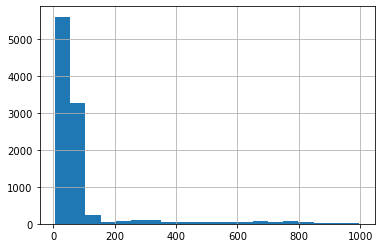

In [33]:
fake['sentilink_synthetic_score'].hist(bins=20)

In [38]:
fake['sentilink_synthetic_score'].quantile([0.9,0.95,0.99])

0.90    114.00
0.95    436.05
0.99    795.00
Name: sentilink_synthetic_score, dtype: float64

In [34]:
fake['sentilink_synthetic_score'].describe()

count    10000.000000
mean        89.882500
std        150.149737
min          5.000000
25%         29.000000
50%         48.000000
75%         75.000000
max        997.000000
Name: sentilink_synthetic_score, dtype: float64

## left skewed distribution
- half of the users have score under 48, meaning there's low probability of fraud
- 10% of users have scores above 114, and even that's low threshold for synthetic fraud

<AxesSubplot:>

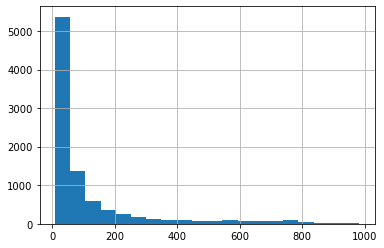

In [40]:
fake['sentilink_id_theft_score'].hist(bins=20)

In [41]:
fake['sentilink_id_theft_score'].quantile([0.9,0.95,0.99])

0.90    337.00
0.95    581.70
0.99    815.74
Name: sentilink_id_theft_score, dtype: float64

In [39]:
fake['sentilink_id_theft_score'].describe()

count    9127.000000
mean      118.239619
std       178.775570
min         9.000000
25%        24.000000
50%        43.000000
75%       113.000000
max       983.000000
Name: sentilink_id_theft_score, dtype: float64

## left skewed distribution
- half of the users have score sunder 43, meaning there's low probability of id theft
- 10% of users have scores above 337

## 5. What is your best estimate of the rate of synthetic fraud in different bins of the synthetic score? Same question for the identity theft score and identity theft.
- Bonus: estimate with uncertainty.

In [87]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   unique_id                  10000 non-null  object  
 1   sentilink_id_theft_score   9127 non-null   float64 
 2   sentilink_synthetic_score  10000 non-null  int64   
 3   label                      256 non-null    object  
 4   is_id_theft                256 non-null    float64 
 5   is_synthetic               256 non-null    float64 
 6   charged_off                9014 non-null   object  
 7   booked                     10000 non-null  bool    
 8   syn_bins                   10000 non-null  category
 9   theft_bins                 9127 non-null   float64 
dtypes: bool(1), category(1), float64(4), int64(1), object(3)
memory usage: 645.4+ KB


In [213]:
fake.groupby(['label','is_synthetic']).size()

label                  is_synthetic
clear                  0.0             59
first_party_synthetic  1.0             89
id_theft               0.0             75
third_party_synthetic  1.0             33
dtype: int64

In [212]:
fake.groupby(['label','is_id_theft']).size()

label                  is_id_theft
clear                  0.0            59
first_party_synthetic  0.0            89
id_theft               1.0            75
third_party_synthetic  0.0            33
dtype: int64

In [124]:
fake['has_label'] = fake['label'].notna()

In [180]:
fake['theft_bins'] =pd.qcut(fake['sentilink_id_theft_score'],10)

In [137]:
sampling_rate = fake[fake['has_label']].groupby('theft_bins').size()/fake.groupby('theft_bins').size()
sampling_rate

theft_bins
(8.999, 18.0]     0.011788
(18.0, 22.0]      0.009923
(22.0, 26.0]      0.007335
(26.0, 33.0]      0.010040
(33.0, 43.0]      0.009050
(43.0, 60.0]      0.017998
(60.0, 89.0]      0.007910
(89.0, 151.0]     0.016520
(151.0, 337.0]    0.028571
(337.0, 983.0]    0.145833
dtype: float64

## the manuals labels are not uniformly sampled across the bins

In [190]:
theft_bin_rate = fake.groupby(['theft_bins','is_id_theft']).size()/fake[fake['has_label']].groupby('theft_bins').size()

In [191]:
theft_bin_rate.reset_index()

,theft_bins,is_id_theft,0
0,"(8.999, 18.0]",0.0,1.000000
1,"(8.999, 18.0]",1.0,0.000000
2,"(18.0, 22.0]",0.0,1.000000
3,"(18.0, 22.0]",1.0,0.000000
4,"(22.0, 26.0]",0.0,1.000000
5,"(22.0, 26.0]",1.0,0.000000
6,"(26.0, 33.0]",0.0,1.000000
7,"(26.0, 33.0]",1.0,0.000000
8,"(33.0, 43.0]",0.0,1.000000
9,"(33.0, 43.0]",1.0,0.000000


# the fraction of actual fraud is 
- 0% in the lower quantiles but it is 3% and 53% in the 80th and 90th percentile
- We are making an assumption that fraud rate in the sampled pop is equivalent to the fraud rate in the entire bin

In [215]:
fake['sentilink_synthetic_score'].describe()

count    10000.000000
mean        89.882500
std        150.149737
min          5.000000
25%         29.000000
50%         48.000000
75%         75.000000
max        997.000000
Name: sentilink_synthetic_score, dtype: float64

In [221]:
fake['syn_cut'] = pd.cut(fake['sentilink_synthetic_score'],range(0,1100,100))

In [222]:
rate = fake.groupby(['syn_cut','is_synthetic']).size()/fake[fake['has_label']].groupby('syn_cut').size()

In [223]:
rate.reset_index()

,syn_cut,is_synthetic,0
0,"(0, 100]",0.0,1.000000
1,"(0, 100]",1.0,0.000000
2,"(100, 200]",0.0,1.000000
3,"(100, 200]",1.0,0.000000
4,"(200, 300]",0.0,1.000000
5,"(200, 300]",1.0,0.000000
6,"(300, 400]",0.0,1.000000
7,"(300, 400]",1.0,0.000000
8,"(400, 500]",0.0,0.875000
9,"(400, 500]",1.0,0.125000


In [181]:
fake['syn_bins'] =pd.qcut(fake['sentilink_synthetic_score'],10)

In [188]:
syn_bin_rate = fake.groupby(['syn_bins','is_synthetic']).size()/fake[fake['has_label']].groupby('syn_bins').size()

In [189]:
syn_bin_rate.reset_index()

,syn_bins,is_synthetic,0
0,"(4.999, 19.0]",0.0,1.000000
1,"(4.999, 19.0]",1.0,0.000000
2,"(19.0, 26.0]",0.0,1.000000
3,"(19.0, 26.0]",1.0,0.000000
4,"(26.0, 32.0]",0.0,1.000000
5,"(26.0, 32.0]",1.0,0.000000
6,"(32.0, 38.0]",0.0,1.000000
7,"(32.0, 38.0]",1.0,0.000000
8,"(38.0, 48.0]",0.0,1.000000
9,"(38.0, 48.0]",1.0,0.000000


## Likewise for the synthetic fraud, 0% in all bins 
- except the 90th percentile where it is 78.7%
- to calculate uncertainty, I would use the margin error calculation

In [183]:
fake.groupby(['syn_bins', 'has_label']).size()

syn_bins        has_label
(4.999, 19.0]   False        1102
                True           12
(19.0, 26.0]    False         958
                True            9
(26.0, 32.0]    False        1021
                True            6
(32.0, 38.0]    False         897
                True            6
(38.0, 48.0]    False        1008
                True           12
(48.0, 59.0]    False         994
                True           16
(59.0, 70.0]    False        1023
                True           13
(70.0, 81.0]    False         935
                True           19
(81.0, 114.0]   False         974
                True            8
(114.0, 997.0]  False         832
                True          155
dtype: int64

In [184]:
# uncertainty using the margin error formula
1.96*np.sqrt(.787097*0.212903/(155))

0.06444589232634818

## 6. What is your best estimate of the rate of synthetic fraud overall? What is the rate of identity theft overall?

In [143]:
len(fake[fake['has_label']])

256

In [147]:
# raw rates synthetic fraud rate
fake.groupby(['is_synthetic']).size()/256


is_synthetic
0.0    0.523438
1.0    0.476562
dtype: float64

## numbers are a little too high given the sample rate by bins
- we can use weighted mean of bins

In [185]:
fake.groupby('syn_bins').size()

syn_bins
(4.999, 19.0]     1114
(19.0, 26.0]       967
(26.0, 32.0]      1027
(32.0, 38.0]       903
(38.0, 48.0]      1020
(48.0, 59.0]      1010
(59.0, 70.0]      1036
(70.0, 81.0]       954
(81.0, 114.0]      982
(114.0, 997.0]     987
dtype: int64

In [192]:
# calculate the overall synthetic fraud rate using weighted means
# the rate for the other bins is zero
(987*0.787097)/10000

0.07768647390000001

## naive theft fraud rate

In [148]:
fake.groupby(['is_id_theft']).size()/256


is_id_theft
0.0    0.707031
1.0    0.292969
dtype: float64

In [153]:
fake['theft_bins'].isnull().value_counts()

False    9127
True      873
Name: theft_bins, dtype: int64

In [155]:
fake.groupby('theft_bins').size()

theft_bins
(8.999, 18.0]     1018
(18.0, 22.0]       907
(22.0, 26.0]       818
(26.0, 33.0]       996
(33.0, 43.0]       884
(43.0, 60.0]       889
(60.0, 89.0]       885
(89.0, 151.0]      908
(151.0, 337.0]     910
(337.0, 983.0]     912
dtype: int64

In [193]:
theft_bin_rate.reset_index()

,theft_bins,is_id_theft,0
0,"(8.999, 18.0]",0.0,1.000000
1,"(8.999, 18.0]",1.0,0.000000
2,"(18.0, 22.0]",0.0,1.000000
3,"(18.0, 22.0]",1.0,0.000000
4,"(22.0, 26.0]",0.0,1.000000
5,"(22.0, 26.0]",1.0,0.000000
6,"(26.0, 33.0]",0.0,1.000000
7,"(26.0, 33.0]",1.0,0.000000
8,"(33.0, 43.0]",0.0,1.000000
9,"(33.0, 43.0]",1.0,0.000000


# theft fraud rate using weighted average

In [156]:
(910*0.038462 + 912*0.533835)/ (9127)

0.057177379204557906

## 7. What fraction of charge-offs are due to either synthetic fraud or identity theft?


In [176]:
fake['charged_off'].value_counts()

False    8298
True      716
Name: charged_off, dtype: int64

In [194]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   unique_id                  10000 non-null  object  
 1   sentilink_id_theft_score   9127 non-null   float64 
 2   sentilink_synthetic_score  10000 non-null  int64   
 3   label                      256 non-null    object  
 4   is_id_theft                256 non-null    float64 
 5   is_synthetic               256 non-null    float64 
 6   charged_off                9014 non-null   object  
 7   booked                     10000 non-null  bool    
 8   syn_bins                   10000 non-null  category
 9   theft_bins                 9127 non-null   category
 10  has_label                  10000 non-null  bool    
dtypes: bool(2), category(2), float64(3), int64(1), object(3)
memory usage: 587.5+ KB


In [224]:
fake['unique_id'].describe()

count             10000
unique            10000
top       53e42eae795f8
freq                  1
Name: unique_id, dtype: object

In [225]:
fake[fake['sentilink_synthetic_score'] > 900]

,unique_id,sentilink_id_theft_score,sentilink_synthetic_score,label,is_id_theft,is_synthetic,charged_off,booked,syn_bins,theft_bins,has_label,charged_null,syn_cut
115,1bce13fa6e9d2,162.0,992,third_party_synthetic,0.0,1.0,NaN,False,"(114.0, 997.0]","(151.0, 337.0]",True,True,"(900, 1000]"
425,1e56ceb7e2ab3,30.0,953,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(26.0, 33.0]",True,False,"(900, 1000]"
1143,d92c6c2a4f54d,65.0,968,NaN,NaN,NaN,False,False,"(114.0, 997.0]","(60.0, 89.0]",False,False,"(900, 1000]"
1654,9e41cfff7be16,70.0,997,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(60.0, 89.0]",True,False,"(900, 1000]"
2147,f2c27ca161961,26.0,982,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(22.0, 26.0]",True,False,"(900, 1000]"
2596,875f982b05d16,27.0,965,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(26.0, 33.0]",True,False,"(900, 1000]"
2973,1c20df39e6601,45.0,946,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(43.0, 60.0]",True,False,"(900, 1000]"
3279,64155f44ff7ad,18.0,973,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(8.999, 18.0]",True,False,"(900, 1000]"
3299,7135439d52d7f,22.0,932,first_party_synthetic,0.0,1.0,False,False,"(114.0, 997.0]","(18.0, 22.0]",True,False,"(900, 1000]"
3402,c22b2f907364f,NaN,972,NaN,NaN,NaN,False,True,"(114.0, 997.0]",NaN,False,False,"(900, 1000]"


In [196]:
# we don't have duplicate ids
fake[(fake['is_id_theft'] == 1) | (fake['is_synthetic'] == 1)]['unique_id'].describe()

count               197
unique              197
top       a8eec1460e8d5
freq                  1
Name: unique_id, dtype: object

In [177]:
fake[(fake['is_id_theft'] == 1) | (fake['is_synthetic'] == 1)]['charged_off'].value_counts()

False    167
True      19
Name: charged_off, dtype: int64

In [178]:
# fraction of charged_off due to either fraud
19/716

0.02653631284916201

## 8. If you were creating a quality assurance process to check files like this before returning
- to prospective customers, what would be some checks you would want to include in this
process? Assume that you would be able to run queries against database tables to
access other information we may have about these, such as raw application information
(name, DOB, SSN, address, phone, email). You can write sentences or bullet points to
describe the checks you would consider.

- check the id's make sure they are valid. no duplicates, correspond to real persons
- check the scores, make sure the distribution of the scores make sense. 
- Check the manual scores is consistent with the raw information DOB and ssn and the like. 
- Are nulls expected?
- Do the median scores make sense given the data?